In [ ]:
#!apt-get install net-tools # To see my interface
!apt-get install tcpdump # To capture packages
#!apt-get install dnsutils
!apt-get install curl # To create traffic to websites
!apt-get install tshark #

In [2]:
!pip install pyshark
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00


In [20]:
import pyshark
import os
import pandas as pd # To get benefits of data frames
import nest_asyncio # Helpful while reading pcap files
from datetime import datetime # To deal with timestamps
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/NMDA/HW2"

Mounted at /content/drive


In [4]:
! mkdir captures

In [106]:
! rm captures/*
! rm data/*
! rm *.zip
! rm *.csv

Since the location of the Colab VM might affect the flow features, I check the location of the VM, while creating the next dataset I make sure that I am in the same location.

In [107]:
import urllib
import json
def get_information(ip):
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']
        return country, city, latitude, longitude

api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude

('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

In [108]:
! bash capture.sh captures capture \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
1636 packets captured2732 packets captured

1636 packets received by filter2732 packets received by filter

0 packets dropped by kernel0 pac

The next cell is just to create a zip file of the captures in order to be downloaded or transferred

In [109]:
import zipfile
directory_to_zip = "/content/captures"
zip_file_name = "captures_tcp_udp.zip"

# Create a zipfile object in write mode
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files and folders within the directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

In the next cell, a dataframe is created from the pcaps.

In [110]:
import pyshark
import os
import pandas as pd
import nest_asyncio
from datetime import datetime # To deal with timestamps
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initialize CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                 'udp.srcport': [], 'udp.dstport': [],
                 'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto': [], 'ip.len': [], 'frame.time': []}

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)
        # Extract label from filename
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Read the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
            address_a = packet.ip.src
            address_b = packet.ip.dst
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time  # Assign directly, no need for strptime
            protocol = packet.ip.proto
            ip_len = packet.ip.len
            frame_time = packet.sniff_time

            if 'tcp' in packet:
                tcp_srcport = packet.tcp.srcport
                tcp_dstport = packet.tcp.dstport
            else:
                tcp_srcport = None
                tcp_dstport = None

            if 'udp' in packet:
                udp_srcport = packet.udp.srcport
                udp_dstport = packet.udp.dstport
            else:
                udp_srcport = None
                udp_dstport = None

            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['udp.srcport'].append(udp_srcport)
                CONVERSATIONS['udp.dstport'].append(udp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)
                continue  # Move to the next packet

            CONVERSATIONS['bytes'][loc] += int(packet_bytes)
            CONVERSATIONS['packets'][loc] += 1
            CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
            CONVERSATIONS['ip.proto'][loc] = protocol
            CONVERSATIONS['ip.len'][loc] = ip_len
            CONVERSATIONS['frame.time'][loc] = frame_time

# Create DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

# Display the DataFrame
print(df)


                ip.src           ip.dst tcp.srcport tcp.dstport udp.srcport  \
0          172.28.0.12  169.254.169.254        None        None       39966   
1          172.28.0.12  169.254.169.254        None        None       60222   
2      169.254.169.254      172.28.0.12        None        None          53   
3      169.254.169.254      172.28.0.12        None        None          53   
4          172.28.0.12     23.37.16.130       46196         443        None   
...                ...              ...         ...         ...         ...   
19066  169.254.169.254      172.28.0.12        None        None          53   
19067      172.28.0.12  169.254.169.254        None        None       43714   
19068      172.28.0.12  169.254.169.254        None        None       53045   
19069  169.254.169.254      172.28.0.12        None        None          53   
19070  169.254.169.254      172.28.0.12        None        None          53   

      udp.dstport  bytes  packets                  

In [111]:
total_udp_packets = len(df[df['ip.proto'] == '17'])
print("Total number of UDP packets:", total_udp_packets)


Total number of UDP packets: 2290


In [112]:
! mkdir data
df.to_csv('data/df_flows_tcp_udp.csv', index=False)


mkdir: cannot create directory ‘data’: File exists


In [113]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='10'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_tcp = extract_features(flow,df_flow)

for flow,df_flow in df_flows_udp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_udp = extract_features(flow,df_flow)




In [114]:
path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_tcp = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    if(flow_features['direction']=='downlink'):
      dataset_tcp = dataset_tcp.append(flow_features,ignore_index=True);

path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_udp = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==17]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
  for flow,df_flow in df_flows_udp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    if(flow_features['direction']=='downlink'):
      dataset_udp = dataset_udp.append(flow_features,ignore_index=True);

dataset_tcp.head()
dataset_udp.head()
dataset_tcp.to_csv('traffic_classification_tcp_dataset.csv', index=False, line_terminator='\n')
dataset_udp.to_csv('traffic_classification_udp_dataset.csv', index=False, line_terminator='\n')



['df'] 1 1
Processing file   df_flows_tcp_udp.csv


<ipython-input-114-dbbe33859169>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_tcp = dataset_tcp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_tcp = dataset_tcp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_tcp = dataset_tcp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_tcp = dataset_tcp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:16: FutureW

['df'] 1 1
Processing file   df_flows_tcp_udp.csv


<ipython-input-114-dbbe33859169>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_udp = dataset_udp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_udp = dataset_udp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_udp = dataset_udp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_udp = dataset_udp.append(flow_features,ignore_index=True);
<ipython-input-114-dbbe33859169>:33: FutureW

max accuracy is at K =  2 with value =  0.9556962025316456


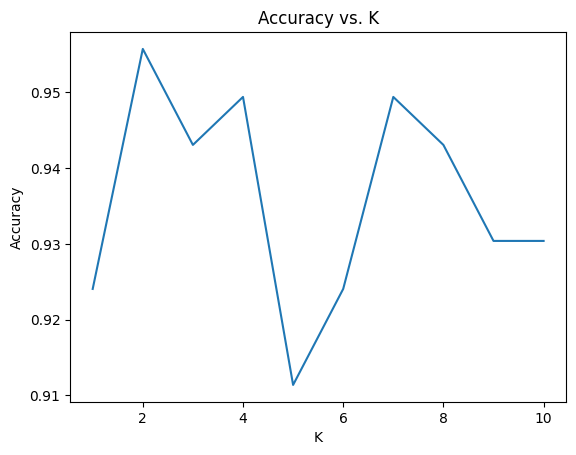

The most accurate result with K =  2


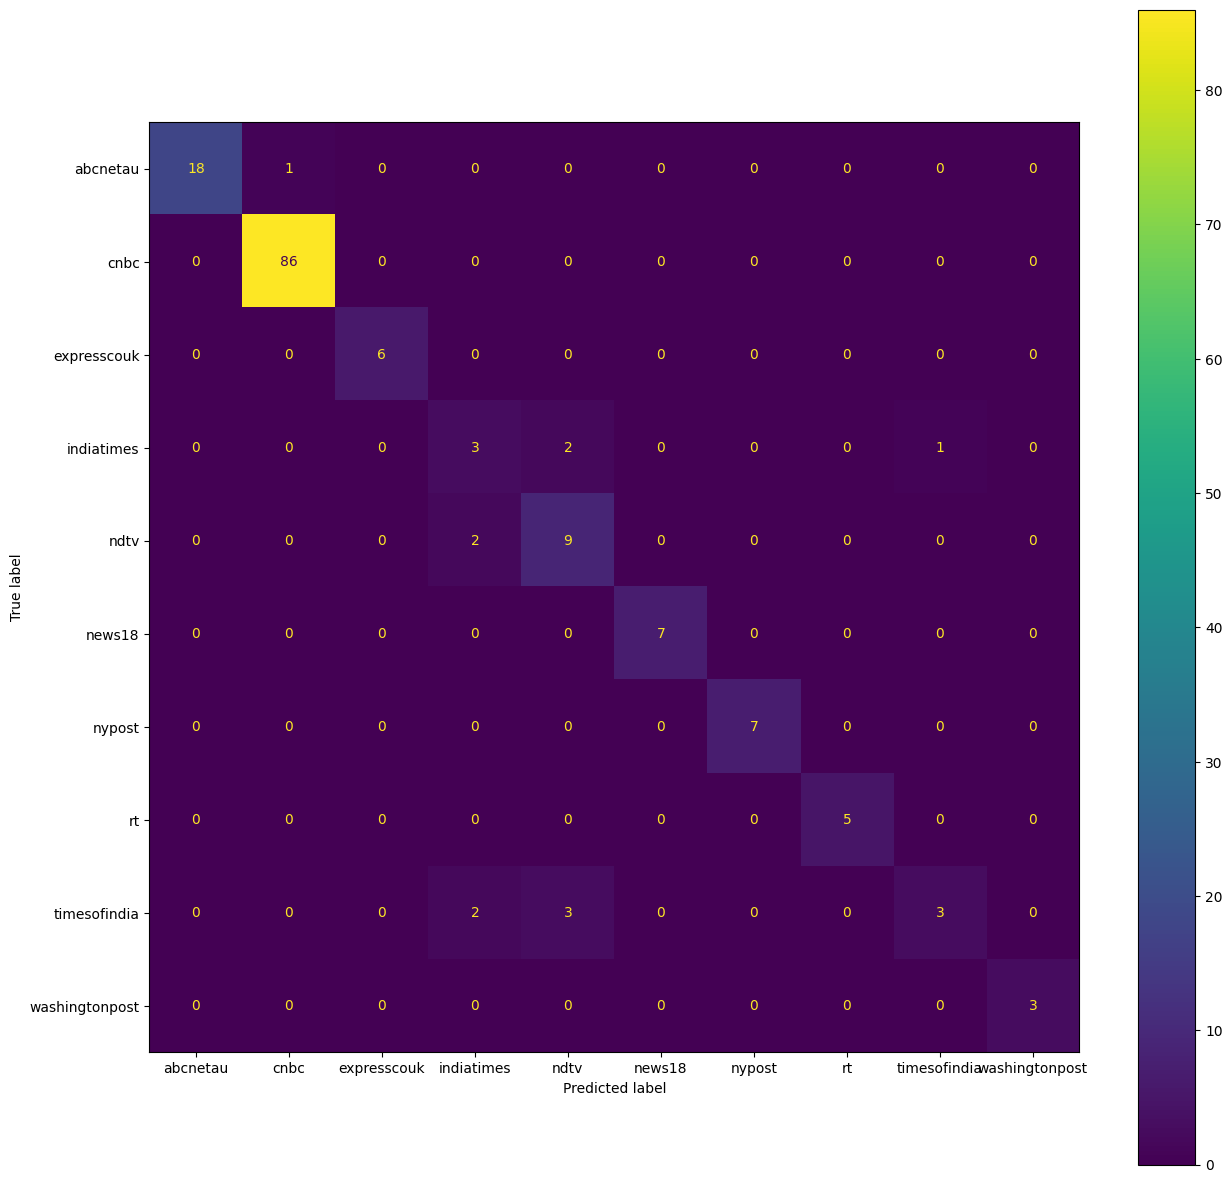

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
X_TCP = dataset_tcp.drop(['direction','sport','dport'],axis=1).dropna();
X_UDP = dataset_udp.drop(['direction','sport','dport'],axis=1).dropna();
X = pd.concat([X_TCP, X_UDP], ignore_index=True)
APP = X['app']
X = X.drop(['app'],axis=1)
APP_test_predicted_best = []
APP_test_best = []
APP_train_best = []

accuracies = np.array([])
for K in range(1,11):

  idx = np.random.permutation(len(X))
  num_train_obs = np.floor(0.7*len(X))
  train_idx = idx[1:int(num_train_obs)]
  test_idx = idx[int(num_train_obs):]

  # normalization
  X_norm = pd.DataFrame()
  for key in X:
    temp = X[key]
    temp_norm = (temp-temp.mean())/temp.std();
    X_norm[key] = temp_norm
  # split train / test
  X_norm_train = X_norm.iloc[train_idx]
  X_norm_test = X_norm.iloc[test_idx]
  APP_train = APP.iloc[train_idx]
  APP_test = APP.iloc[test_idx]

  #K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
  i = 0;
  accuracy = 0
  APP_test_predicted = []
  for index, row in X_norm_test.iterrows():
    #test_entry = row.values.tolist()
    distances = []
    for ii, rr in X_norm_train.iterrows():
      #train_entry = rr.values.tolist()
      #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
      distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

    min_idx = np.argmin(distances)

    #sorted_idx = np.argsort(distances)
    #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

    predicted_app = APP_train.iloc[min_idx]
    APP_test_predicted.append(predicted_app)
    if(APP_test.iloc[i] == predicted_app):
        accuracy = accuracy+1
    i = i+1
  if(K > 1):
    if (accuracies.max() < accuracy/len(APP_test)):
      APP_test_predicted_best = APP_test_predicted
      APP_test_best = APP_test
      APP_train_best = APP_train
    else:
      APP_test_predicted_best = APP_test_predicted
      APP_test_best = APP_test
      APP_train_best = APP_train

  accuracies = np.append(accuracies, accuracy/len(APP_test))

K = np.argmax(accuracies) + 1
print("max accuracy is at K = ",K, "with value = ", accuracies[K-1])

# Assuming accuracies is already populated with accuracy values
K_values = np.arange(1, len(accuracies) + 1)

# Plotting the accuracies against K+1
plt.plot(K_values, accuracies)

# Adding labels and title
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')

# Displaying the plot
plt.show()

print("The most accurate result with K = ", K)

fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted_best, APP_test_best, ax=ax);
np.save('predictor.npy', APP_train_best)
